In [1]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import copy
%matplotlib widget



print('libraries imported')

libraries imported


Wearable-based signals during physical exercises from patients with frailty after open-heart surgery

Important notes from data description: 

ECG, sampled at 130 Hz, and triaxial acceleration signals, sampled at 200 Hz, were obtained using Polar H10 (Polar Electro OY, Kempele, Finland) wearable device.

The records are named as follows:

xxx_y_zzz,

where xxx is the patient ID, y is the recording session number, and zzzis ecg for the ECG signal and acc for the acceleration signals (ACC_X, ACC_Y, and ACC_Z).

For each record, signals are stored in a signal file (.dat). The record’s header file (.hea) specifies its name, duration, storage format, sampling frequency, and the time of day the signal acquisition started. The record’s annotation file (.atr) contains reference annotations of the onsets of the exercise tests, that have been manually checked for accuracy. Gait analysis is an exception because its annotation mark is a system-provided time of the generated gait analysis report, which has not been manually checked for accuracy. The following codes are used for annotations:

However, when using the signals, researchers should be aware of these limitations: (1) since the sampling frequency of the Polar H10 device is not perfectly constant (varies up to 0.2%), the ECG and acceleration signals were resampled at uniform sampling frequencies of 130 Hz and 200 Hz, respectively; (2) some ECG signals might be unsuitable for analysis due to poor quality; (3) in some cases, patients were walking longer than 6 minutes while performing the 6MWT; (4) sometimes motion is present before and/or after the exercise test despite the fact that the patient was asked to rest in a sitting position for at least 3 minutes; (5) the Zebris system provides the time of the gait analysis report to the nearest minute, thus it might be difficult to estimate the start and end of the 30-s-long gait analysis precisely; (6) the GAIT_ANALYSIS annotation marker is preceded not only by the resting period but also by the preparation period; (7) it is possible to place the chest strap upside down, so vertical (ACC_X) and mediolateral (ACC_Y) acceleration signals might be inverted in some cases.

When using the subject-info.csv file, researchers should pay attention to the following: (1) heart failure class according to New York Heart Association (NYHA) classification criteria is not provided for the patient 073; (2) the results of the gait analysis for the patient 254 are somehow erroneous; (3) patients 203 and 250 did not perform gait analysis due to dizziness; (4) patient 269 did not perform veloergometry; (5) stride length and stride time are not provided for the patient 318.

Load demographic patient data

In [2]:
#load demographic data

# Define the file paths
subject_info_path = 'C:\\Users\\20181588\\Desktop\\data\\accelerometry_wearables_heart_surgery_recovery\\wearable-based-signals-during-physical-exercises-from-patients-with-frailty-after-open-heart-surgery-1.0.0\\subject-info.csv'

# Read the data into pandas DataFrames
subject_info_df = pd.read_csv(subject_info_path)

subject_info_df.head()

,Unnamed: 0,General information,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Surgery information,Unnamed: 7,Comorbidities,Unnamed: 9,...,Unnamed: 33,Unnamed: 34,Unnamed: 35,Gait analysis: balance parameters (mean±std),Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
0,Patient ID,"Age, years","Gender (0 - male, 1 - female)","Height, cm","Weight, kg",EFS score,Days after surgery,Surgery type (0 - coronary artery bypass graft...,Heart failure based on NYHA class,"Atrial fibrillation (0 - no AF, 1 - permanent,...",...,"Stride time, s","Cadence, steps/min","Velocity, km/h","Length of gait line (left), mm","Length of gait line (right), mm","Single limb support line (left), mm","Single limb support line (right), mm","Ant/post position, mm","Lateral symmetry, mm","Max gait line velocity, cm/s"
1,001,77,0,170,76,6,21,2,II,0,...,1.26±0.05,96±4,0.8±0.1,150.5±22.5,134.1±19.8,21.6±6.9,18.8±7.4,11.0±11.1,11.5±47.5,578
2,012,69,0,177,110,6,20,2,III,3,...,1.65±0.06,73±3,1.1±0.1,129.6±11.2,147.8±6.0,26.3±7.6,31.7±10.5,11.0±7.5,-11.9±38.4,109.9
3,020,74,0,183,95,7,13,0,II,0,...,1.32±0.05,91±3,1.8±1,65.8±20.3,136.4±17.9,24.8±8.4,38.3±15.2,25.0±8.3,-23.4±34.8,457.9
4,026,70,1,150,72,6,14,0,II,0,...,1.25±0.04,96±3,1.5±0.1,131.1±6.9,129.1±7.9,19.1±9.2,20.0±9.2,3.7±6.9,-3.7±24.6,128.7


Load Test availability data

In [3]:
#load test infor data
# Define the file paths
test_availability_path = 'C:\\Users\\20181588\\Desktop\\data\\accelerometry_wearables_heart_surgery_recovery\\wearable-based-signals-during-physical-exercises-from-patients-with-frailty-after-open-heart-surgery-1.0.0\\test-availability.csv'

# Read the data into pandas DataFrames
test_availability_df = pd.read_csv(test_availability_path)

test_availability_df.head()

,Patient ID,STAIR,6MWT,TUG,VELO,GAIT_ANALYSIS
0,1,001_1,001_1,001_1,001_1,001_1
1,12,012_2,012_1,012_1,012_3,-
2,20,-,-,020_1,020_2,020_1
3,26,-,026_1,026_1,026_1,-
4,36,036_1,036_1,036_1,036_1,-


Load Accelerometry data

In [4]:
#Load Accelerometry data
# Define the path to your data without the file extension
acc_record_path = 'C:\\Users\\20181588\\Desktop\\data\\accelerometry_wearables_heart_surgery_recovery\\wearable-based-signals-during-physical-exercises-from-patients-with-frailty-after-open-heart-surgery-1.0.0\\acc\\001_1_acc'


In [5]:
# Define the path to the .hea file
acc_hea_file_path = 'C:\\Users\\20181588\\Desktop\\data\\accelerometry_wearables_heart_surgery_recovery\\wearable-based-signals-during-physical-exercises-from-patients-with-frailty-after-open-heart-surgery-1.0.0\\acc\\001_1_acc.hea'

# Open the file and read its contents
with open(acc_hea_file_path, 'r') as file:
    acc_hea_contents = file.read()

# Print the contents
print(acc_hea_contents)

001_1_acc 3 200 1121634
001_1_acc.dat 32 2273762.9398(2147483647)/g 0 0 10938741 -6732 0 ACC_X
001_1_acc.dat 32 3872989.9041(222273827)/g 0 0 154802696 9875 0 ACC_Y
001_1_acc.dat 32 2180767.9608(270131075)/g 0 0 822851690 -7175 0 ACC_Z
#11:33:17


In [6]:
# Read the Accelerometry record and the corresponding annotations
acc_record_original = wfdb.rdrecord(acc_record_path)
acc_annotation_original = wfdb.rdann(acc_record_path, 'atr')

# Make deep copies
acc_record = copy.deepcopy(acc_record_original)
acc_annotation = copy.deepcopy(acc_annotation_original)

Load ECG data


In [7]:
#Load ECG data
# Define the path to your data without the file extension
ecg_record_path = 'C:\\Users\\20181588\\Desktop\\data\\accelerometry_wearables_heart_surgery_recovery\\wearable-based-signals-during-physical-exercises-from-patients-with-frailty-after-open-heart-surgery-1.0.0\\ecg\\001_1_ecg'
# Read the Accelerometry record and the corresponding annotations
ecg_record_original = wfdb.rdrecord(ecg_record_path)
ecg_annotation_original = wfdb.rdann(ecg_record_path, 'atr')

# Make deep copies
ecg_record = copy.deepcopy(ecg_record_original)
ecg_annotation = copy.deepcopy(ecg_annotation_original)

In [8]:
# Define the path to the .hea file
ecg_hea_file_path = 'C:\\Users\\20181588\\Desktop\\data\\accelerometry_wearables_heart_surgery_recovery\\wearable-based-signals-during-physical-exercises-from-patients-with-frailty-after-open-heart-surgery-1.0.0\\ecg\\001_1_ecg.hea'

# Open the file and read its contents
with open(ecg_hea_file_path, 'r') as file:
    ecg_hea_contents = file.read()

# Print the contents
print(ecg_hea_contents)

001_1_ecg 1 130 729078
001_1_ecg.dat 32 766983.7286(-824811852)/mV 0 0 -988442052 8258 0 ECG
#11:33:17


Plots

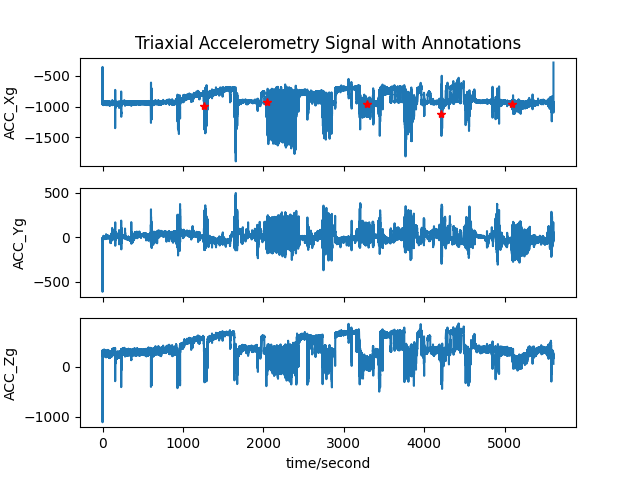

In [9]:
# Plot the Accelerometry signal
wfdb.plot_wfdb(record=acc_record, annotation=acc_annotation,
               title='Triaxial Accelerometry Signal with Annotations',
               time_units='seconds')



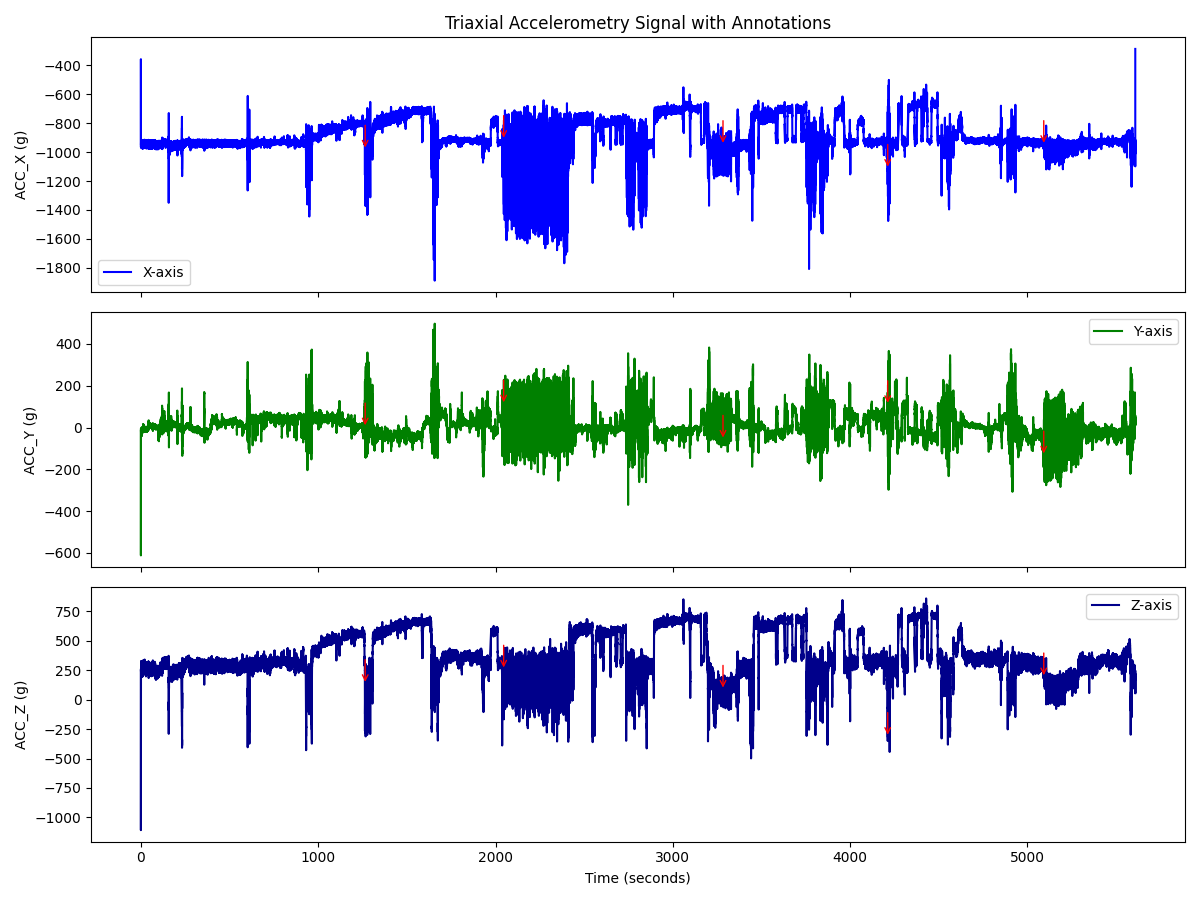

In [10]:
# Create a figure and axes
fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Time vector for x-axis
acc_fs = 200  # Sampling frequency of 200 Hz
acc_time_vector = [i/acc_fs for i in range(len(acc_record.p_signal))]

# Define colors for each component
colors = ['blue', 'green', 'darkblue']

# Plot the X, Y, Z components of the signal with different colors
ax[0].plot(acc_time_vector, acc_record.p_signal[:, 0], label='X-axis', color=colors[0])
ax[1].plot(acc_time_vector, acc_record.p_signal[:, 1], label='Y-axis', color=colors[1])
ax[2].plot(acc_time_vector, acc_record.p_signal[:, 2], label='Z-axis', color=colors[2])

# Add annotations to each subplot
for ann_sample in acc_annotation.sample:
    time = ann_sample / acc_fs
    ax[0].annotate('', xy=(time, acc_record.p_signal[ann_sample, 0]), xytext=(0, 20),
                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='r'))
    ax[1].annotate('', xy=(time, acc_record.p_signal[ann_sample, 1]), xytext=(0, 20),
                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='r'))
    ax[2].annotate('', xy=(time, acc_record.p_signal[ann_sample, 2]), xytext=(0, 20),
                   textcoords='offset points', arrowprops=dict(arrowstyle='->', color='r'))

# Set titles and labels
ax[0].set_title('Triaxial Accelerometry Signal with Annotations')
ax[0].set_ylabel('ACC_X (g)')
ax[1].set_ylabel('ACC_Y (g)')
ax[2].set_ylabel('ACC_Z (g)')
ax[2].set_xlabel('Time (seconds)')

# Show legend
for a in ax:
    a.legend()

plt.tight_layout()
plt.show()

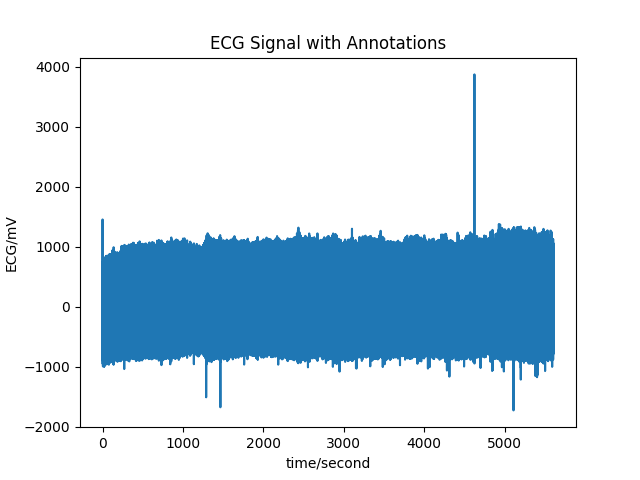

In [15]:
# Plot the ECG signal
wfdb.plot_wfdb(record=ecg_record,
               title='ECG Signal with Annotations',
               time_units='seconds')

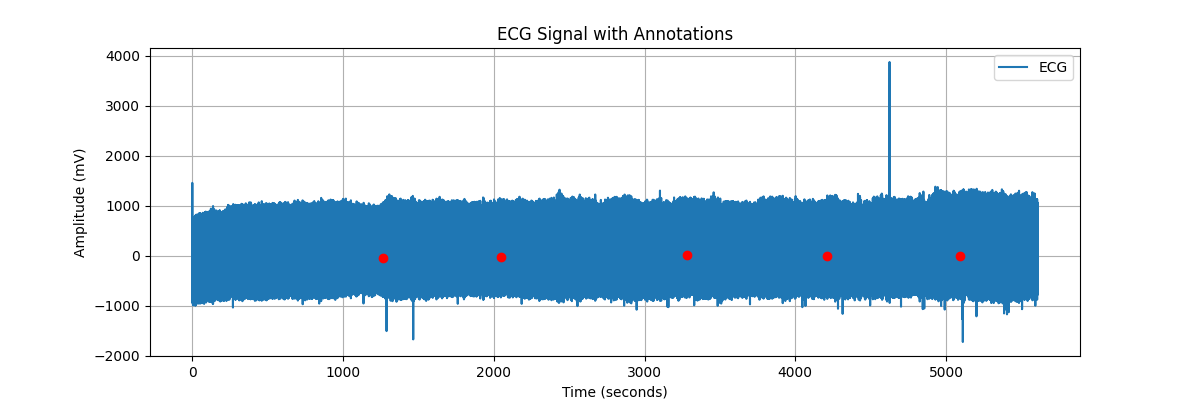

In [17]:
# Assuming ecg_record and ecg_annotation are already read using wfdb.rdrecord and wfdb.rdann

# Set the sampling frequency for ECG
fs = 130

# Create a time vector based on the number of samples and the sampling frequency
time_vector = np.arange(ecg_record.sig_len) / fs

# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_vector, ecg_record.p_signal, label='ECG')

# Plot the annotations on top of the ECG signal
for annotation in ecg_annotation.sample:
    plt.plot(annotation / fs, ecg_record.p_signal[annotation], 'ro')

plt.title('ECG Signal with Annotations')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)
plt.show()

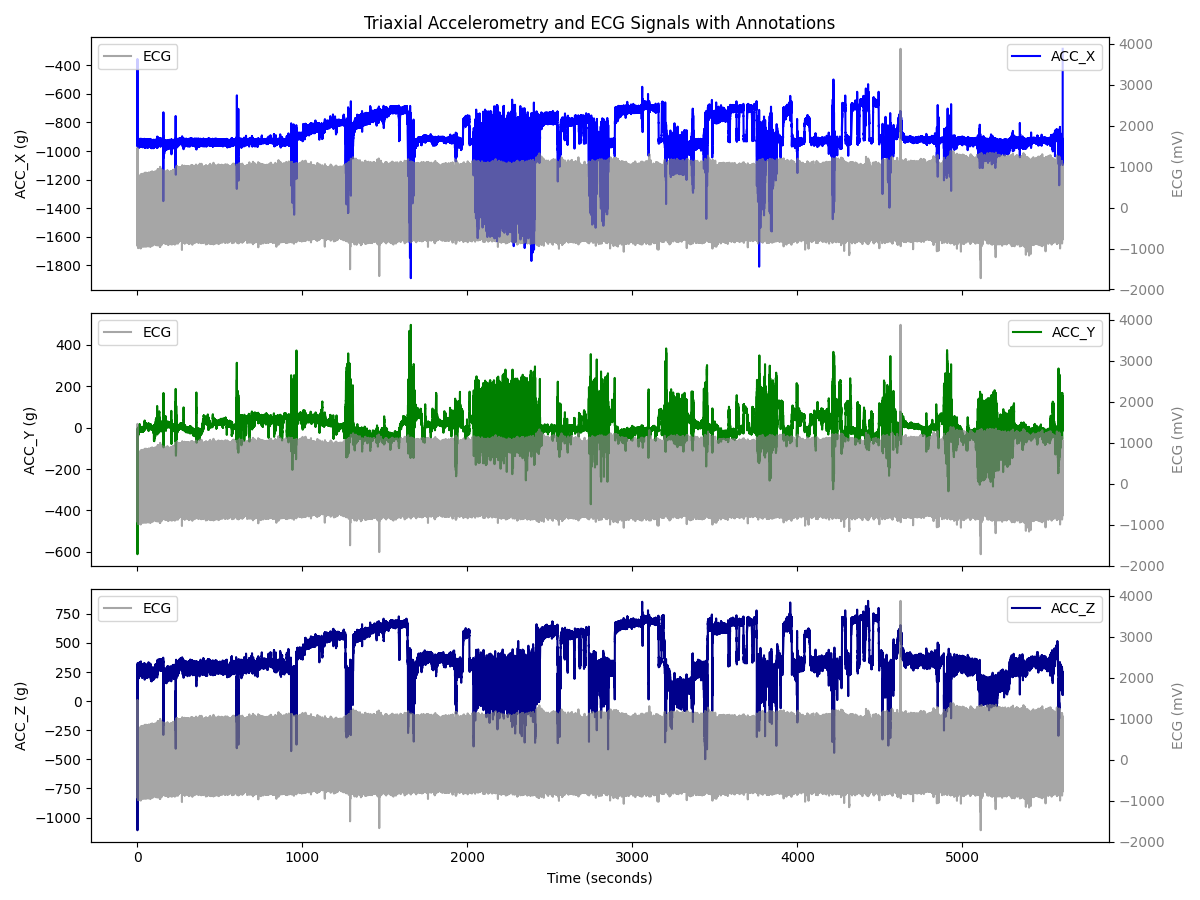

In [20]:
# Create a figure and axes for triaxial accelerometry data
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Time vector for x-axis for accelerometry data
acc_fs = 200  # Sampling frequency of accelerometry data
acc_time_vector = [i/acc_fs for i in range(len(acc_record.p_signal))]

# Time vector for x-axis for ECG data
ecg_fs = 130  # Sampling frequency of ECG data
ecg_time_vector = [i/ecg_fs for i in range(len(ecg_record.p_signal))]

# Define colors for each component
acc_colors = ['blue', 'green', 'darkblue']
ecg_color = 'gray'

# Axis labels
axis_labels = ['X', 'Y', 'Z']

# Plot the X, Y, Z components of the accelerometry signal with different colors
for i, color in enumerate(acc_colors):
    axs[i].plot(acc_time_vector, acc_record.p_signal[:, i], label=f'ACC_{axis_labels[i]}', color=color)
    axs[i].set_ylabel(f'ACC_{axis_labels[i]} (g)')
    axs[i].legend(loc='upper right')

    # Create a second y-axis for the ECG data
    ax2 = axs[i].twinx()
    ax2.plot(ecg_time_vector, ecg_record.p_signal[:, 0], label='ECG', color=ecg_color, alpha=0.7)  # Assuming ECG is single-channel
    ax2.set_ylabel('ECG (mV)', color=ecg_color)
    ax2.tick_params(axis='y', labelcolor=ecg_color)
    ax2.legend(loc='upper left')

# Set titles and labels
axs[0].set_title('Triaxial Accelerometry and ECG Signals with Annotations')
axs[-1].set_xlabel('Time (seconds)')

# Adjust the layout
plt.tight_layout()
plt.show()
